# Sprint 10 - Proyecto

## Descripción del proyecto

Eres analista en una gran tienda online. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.

Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.


## Descripción de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Parte 1: Priorizar hipotesis

Se cargan los datos de hipótesis

In [2]:
# Cargar datos de hipótesis
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';')
hypotheses.columns = hypotheses.columns.str.lower()

In [3]:
hypotheses.columns
print(hypotheses)

                                          hypothesis  reach  impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   
5  Add a customer review page. This will increase...      3       2   
6  Show banners with current offers and sales on ...      5       3   
7  Add a subscription form to all the main pages....     10       7   
8  Launch a promotion that gives users discounts ...      1       9   

   confidence  effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  
5           2       3  
6           8       3  
7           8       5  
8           9       5  


Se calcula el ICE

In [4]:
# Calcular ICE
hypotheses['ice'] = (hypotheses['impact']*hypotheses['confidence']) / hypotheses['effort']
hypotheses_ice = hypotheses[['hypothesis','ice']].sort_values(by='ice', ascending=False)


Se calcula RICE

In [5]:
# Calcular RICE
hypotheses['rice'] = (hypotheses['reach']*hypotheses['impact']*hypotheses['confidence']) / hypotheses['effort']
hypotheses_rice = hypotheses[['hypothesis','rice']].sort_values(by='rice', ascending=False)

Se muestra y se compara rankings

In [6]:
print("\n--- Prioridad por ICE ---")
print(hypotheses_ice)
print("\n--- Prioridad por RICE ---")
print(hypotheses_rice)


--- Prioridad por ICE ---
                                          hypothesis        ice
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000

--- Prioridad por RICE ---
                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  La

Puesto que ICE y RICE son formas de valorar las hipotesis que vale más la pena probar primero, se interpreta lo siguiente:

- Para la valoración ICE en la que se valora Impact, Confidence y Effort, un valor alto en su hipótesis quiere decir que entre estos tres términos tienen prioridad para estos tres términos. Y son las hipotesis 8, 0 y 7.
- Para la valoración RICE se toman en cuenta los tres términos anteriores pero se añade uno más, Reach, que nos dice cuales serán las hipotesis que además impactarán a más personas. Estás hipótesis son la hipótesis, 7, 2 y 0.

Por lo tanto, se debería de empezar en primer lugar con la hipótesis 7, en lo sucesivo la hipótesis 0 y finalmente las hipótesis 8 y 2. Pues son las que tienen una alta prioridad en ambos sistemas de valoración.


## Parte 2: Análisis del test A/B

Cargar datos

In [7]:
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

In [8]:
print(orders)

      transactionId   visitorId        date  revenue group
0        3667963787  3312258926  2019-08-15     30.4     B
1        2804400009  3642806036  2019-08-15     15.2     B
2        2961555356  4069496402  2019-08-15     10.2     A
3        3797467345  1196621759  2019-08-15    155.1     B
4        2282983706  2322279887  2019-08-15     40.5     B
...             ...         ...         ...      ...   ...
1192     2662137336  3733762160  2019-08-14    100.8     B
1193     2203539145   370388673  2019-08-14     50.1     A
1194     1807773912   573423106  2019-08-14    165.3     A
1195     1947021204  1614305549  2019-08-14      5.5     A
1196     3936777065  2108080724  2019-08-15   3120.1     B

[1197 rows x 5 columns]


Preprocesamiento

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

Remover usuarios que estén en ambos grupos

In [10]:
duplicated_users = orders.groupby('visitorId')['group'].nunique()
duplicated_users = duplicated_users[duplicated_users > 1].index
orders = orders[~orders['visitorId'].isin(duplicated_users)]

1. Ingreso acumulado por grupo

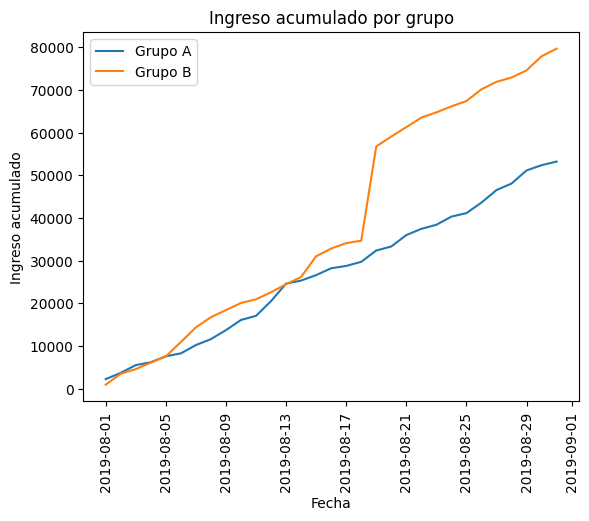

In [11]:
revenue_cum = orders.groupby(['date', 'group']).agg({'revenue':'sum'}).groupby(level=1).cumsum().reset_index()
for group in revenue_cum['group'].unique():
    plt.plot(revenue_cum[revenue_cum['group'] == group]['date'], 
             revenue_cum[revenue_cum['group'] == group]['revenue'], label=f'Grupo {group}')
plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.xticks(rotation=90)
plt.legend()
plt.show()
    

El ingreso acumulado del grupo A y B se mantienen a un ritmo similar del 1ro al 17 del mes de agosto, pero es a partir de agosto 17 en que la diferencia del grupo B se dispara y vuelve a conservar una tendencia. Debido a la naturaleza del cambio y la conservación tendencial se conjetura que se pudo haber abrido un canal nuevo en el ingreso y conservado el ingreso acumulado.

2. Tamaño de pedido promedio acumulado

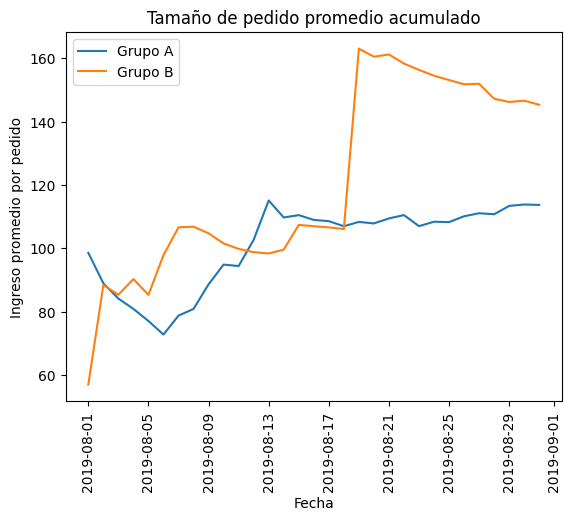

In [12]:
orders_cum = orders.groupby(['date', 'group']).agg({'revenue': ['sum', 'count']})
orders_cum.columns = ['revenue_sum', 'orders_count']
orders_cum = orders_cum.groupby(level=1).cumsum().reset_index()
orders_cum['avg_order'] = orders_cum['revenue_sum'] / orders_cum['orders_count']

for group in orders_cum['group'].unique():
    group_data = orders_cum[orders_cum['group'] == group]
    plt.plot(group_data['date'], group_data['avg_order'], label= f'Grupo {group}')
plt.title('Tamaño de pedido promedio acumulado')
plt.xlabel('Fecha')
plt.ylabel('Ingreso promedio por pedido')
plt.xticks(rotation=90)
plt.legend()
plt.show()

El tamaño de pedido acumulado nos dice que en el grupo B apartir de agosto 17-21 el tamaño promedio tuvo un aumento de casi 60 puntos en su ingreso promedio por pedido, sin embargo, en los sucesivos días fue disminuyendo, lo cuál suma a la conjetura que las ventas se deben a un evento puntual, que con el paso del tiempo va disminuyendo.


3. Diferencia relativa en tamaño de pedido

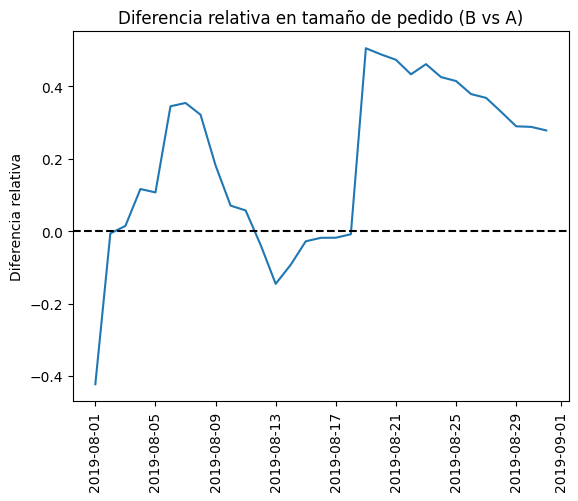

In [13]:
order_A = orders_cum[orders_cum['group'] == 'A'].set_index('date')
order_B = orders_cum[orders_cum['group'] == 'B'].set_index('date')
rel_diff = ((order_B['avg_order'] - order_A['avg_order']) / order_A['avg_order'])
plt.plot(rel_diff.index, rel_diff.values)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Diferencia relativa en tamaño de pedido (B vs A)')
plt.ylabel('Diferencia relativa')
plt.xticks(rotation=90)
plt.show()

La diferencia relativa nos dice igualmente que hubo un cambio entre el 17-21 de agosto, un evento que favorece al grupo B.

4. Tasa de conversión diaria por grupo

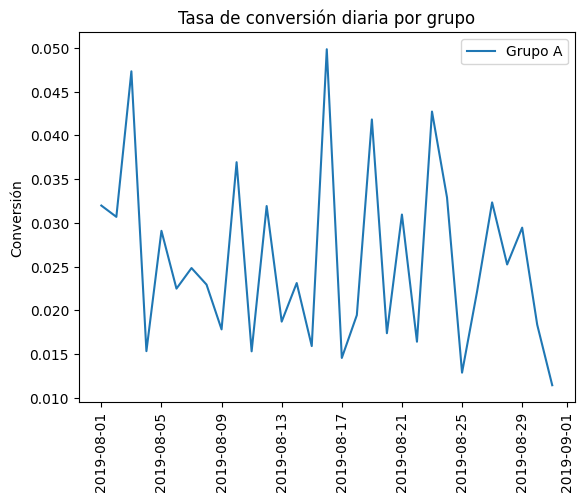

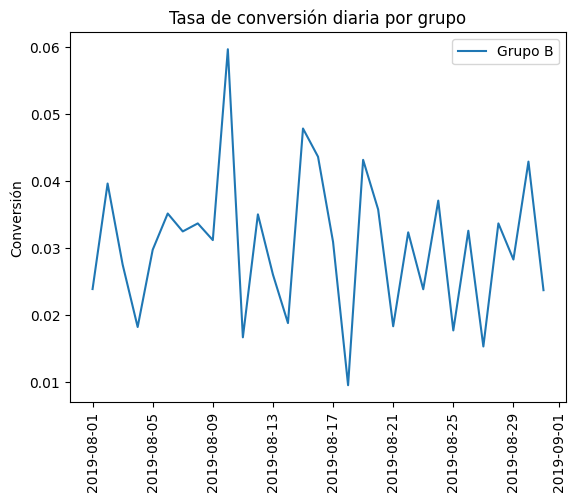

In [14]:
daily_orders = orders.groupby(['date', 'group']).agg({'transactionId':'nunique'}).reset_index()
daily_visits = visits.groupby(['date', 'group']).agg({'visits':'sum'}).reset_index()
daily_data = pd.merge(daily_orders, daily_visits, on=['date','group'])
daily_data['conversion'] = daily_data['transactionId'] / daily_data['visits']

for group in daily_data['group'].unique():
    plt.plot(daily_data[daily_data['group'] == group]['date'], 
            daily_data[daily_data['group'] == group]['conversion'], label = f'Grupo {group}')
    plt.title('Tasa de conversión diaria por grupo')
    plt.ylabel('Conversión')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

Al analizar ambas tasas de conversión se observa que tiene picos más pronunciados en el grupo A, indicando que en el grupo B la tasa de conversión es en su amplia mayoría menor, o en otras palabras, la gente del grupo B no deja pasar tiempo desde que conoce el producto y la compra.

5. Dispersión de pedidos por usuario

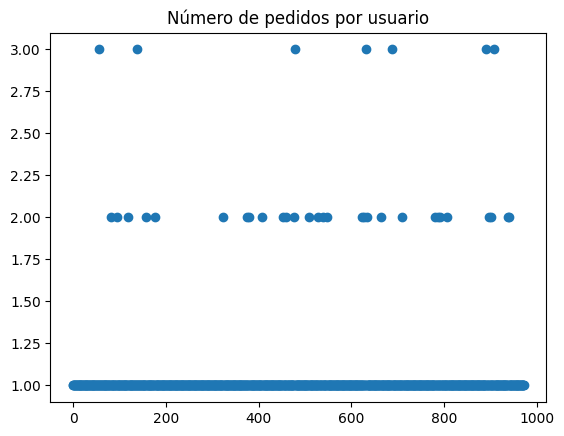

In [15]:
orders_per_user = orders.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index()
orders_per_user.columns = ['visitorId', 'orders']
plt.scatter(range(len(orders_per_user)), orders_per_user['orders'])
plt.title('Número de pedidos por usuario')
plt.show()

La mayoría de los usuarios compra un solo producto, otro grupo comprá 2 productos y son pocos los usuarios que realizan 3 pedidos.

6. Percentiles de pedido por usuario

In [16]:
print('Percentil 95:', np.percentile(orders_per_user['orders'], 95))
print('Percentil 99:', np.percentile(orders_per_user['orders'],99))

Percentil 95: 1.0
Percentil 99: 2.0


7. Dispersión de precios de pedidos

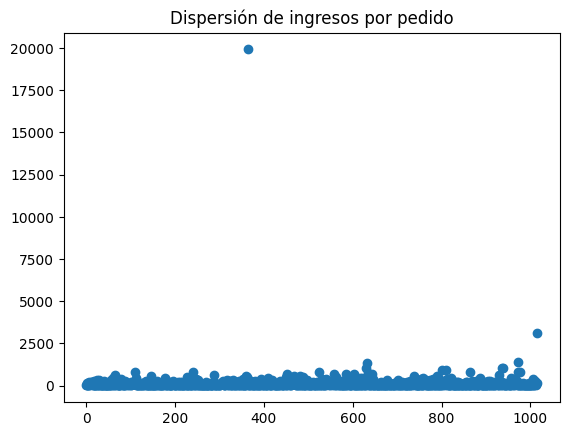

In [17]:
plt.scatter(range(len(orders)), orders['revenue'])
plt.title('Dispersión de ingresos por pedido')
plt.show()

Una amplia mayoría de ingresos por pedidos están por debajo de 2500, y llega a estabilizarse en un número entre el 0 y 1250.

8. Percentiles de precios de pedidos

In [18]:
print('Percentil 95:', np.percentile(orders['revenue'], 95))
print('Percentil 99:', np.percentile(orders['revenue'], 99))

Percentil 95: 414.275
Percentil 99: 830.3


El percentil 95 de 414.275 indica que el 95% de los usuarios gastaron 414.27 o menos. Y solo el 5% de los usuarios gastaron más de esa cantidad.

El percentil 99 de 830.3 indica que el 99% de los usuarios gastaron 830.3 o menos, y solo el 1% de los usuarios gastaron más de esa cantidad.

9 y 10. Pruebas de significancia (datos sin filtrar)

In [19]:
sample_A = orders[orders['group'] == 'A']['visitorId'].nunique()
sample_B = orders[orders['group'] == 'B']['visitorId'].nunique()
conversion_A = orders[orders['group'] == 'A']['transactionId'].nunique() / visits[visits['group'] == 'A']['visits'].sum()
conversion_B = orders[orders['group'] == 'B']['transactionId'].nunique() / visits[visits['group'] == 'B']['visits'].sum()

print("Conversiones: A =", conversion_A, "| B =", conversion_B)
print("Test Mann-Whitney conversión:", stats.mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'],
    orders[orders['group'] == 'B']['revenue'],
    alternative = 'two-sided'
))

Conversiones: A = 0.02497865072587532 | B = 0.02897018397124128
Test Mann-Whitney conversión: MannwhitneyuResult(statistic=129041.5, pvalue=0.8622329690015668)


Las conversiones muestran que el grupo A con una conversión aprox. de 2.50% y el grupo B con una conversión aprox. 2.90%, a simple vista, el grupo B parece tener una mejor conversión, pero por si sola no garantiza que la diferencia sea estadísticamente significativa.

Al realizar el test Mann-Whitney el valor p es 0.8622, superior al nivel típico de significancia de 0.05, por lo que, no hay evidencia estadística suficiente para afirmar que la diferencia en conversión entre A y B sea significativa. Es decir, la diferencia en las tasas de conversión podría deberse al azar.


Filtrado de usuarios anómalos

In [24]:
abnormal_users = orders_per_user[orders_per_user['orders'] >3]['visitorId']
abnormal_revenue_users = orders[orders['revenue'] > 5000]['visitorId']
filtered_users = pd.concat([abnormal_users, abnormal_revenue_users]).drop_duplicates()
orders_filtered = orders[~orders['visitorId'].isin(filtered_users)]

11 y 12. Pruebas de significancia (datos filtrados)

In [25]:
print("\n--- Con datos filtrados ---")
print("Test Mann-Whitney conversión:", stats.mannwhitneyu(
    orders_filtered[orders_filtered['group'] == 'A']['revenue'],
    orders_filtered[orders_filtered['group'] == 'B']['revenue'],
    alternative = 'two-sided'
))


--- Con datos filtrados ---
Test Mann-Whitney conversión: MannwhitneyuResult(statistic=129041.5, pvalue=0.822725753591783)


Esta vez con datos filtrados(Eliminando anomalias) el valor p es de 0.822, el cual sigue siendo mucho mayor que un umbral común de significancia (0.05). Por lo cual no se rechaza la hipótesis nula, lo que quiere decir que no hay diferencias estadísticamente significativas entre las conversiones de los grupos A y B, incluso después de eliminar anomalías.

## Decisión final basada en los resultados

Aunque se hayan limpiado los datos para asegurar mayor confiabilidad, la conversión de los grupos A y B sigue siendo estadísticamente similar. **Esto sugiere que el test A/B no muestra una mejora clara** en conversión al aplicar la condición del grupo B, al menos no una mejora suficientemente fuerte como para ser estadísticamente significativa.

Basado en los resultados de la conversión y el ingreso promedio, y tras eliminar valores atípicos, se determina detener la prueba, y concluir que no hay diferencia entre los grupos.